In [57]:
import pandas as pd
import numpy as np
import os
import scipy
import itertools
#os.environ['XGBOOST_BUILD_DOC'] = 'C:\\Users\\sushant\\Anaconda2\\lib\\site-packages\\xgboost;'
import matplotlib.pyplot as plt    
import xgboost
iv=['np'	, 'os'	 ,'pd'	, 'plt'	 ,'tqdm'	, 'train'	 ,'train_date'	, 'train_date_num'	, 'train_num'	 ]
def memchk(iv):
    import sys,operator
    ipython_vars=iv
    ,'warnings'	, 'xgboost']
    print sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    return sorted([{i:sys.getsizeof(globals().get(i))/1000000.0} for i in ipython_vars])
%matplotlib inline
from IPython.display import Markdown, display
from sklearn.metrics import confusion_matrix
import warnings
%load_ext autotime
def printmd(string):
    display(Markdown(string))

warnings.filterwarnings('ignore')
from tqdm import tqdm

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 68 ms


length of Chunks :100000

In [58]:
rlimit=5000

time: 70 ms


### Reading Numeric Train 

#### Id & Response columns only
```
Reading data in chunks,
Counting Response 
Listing respective indices of Response
```

In [59]:
res1=0
res0=0
ind1=[]
ind0=[]
id1=[]
id0=[]
for i in tqdm(range(1,13)):
    train_Num_part = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Numeric\\train_'+str(i)+'.gzip', chunksize=rlimit,compression='gzip',usecols=['Id','Response'])
    for chunk in train_Num_part:
        res1=res1+len(chunk[chunk['Response']==1])
        res0=res0+len(chunk[chunk['Response']==0])
        ind1.extend(chunk[chunk['Response']==1].index.tolist())
        ind0.extend(chunk[chunk['Response']==0].index.tolist())
        id1.extend(chunk[chunk['Response']==1].Id.tolist())
        id0.extend(chunk[chunk['Response']==0].Id.tolist())
        del chunk
        
    

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:45<00:00,  3.62s/it]


time: 48.5 s



#### Checking Response Ratio 


In [60]:
print 'Faulty Rows :',res1, '\nRemaining rows :', res0
printmd('### '+str(res1*1000.0/res0)+ '  faults per thousand rows')

Faulty Rows : 6879 
Remaining rows : 1176868


### 5.84517549972  faults per thousand rows

time: 16 ms


* Length of index list & Id list

In [61]:
len(ind1),len(ind0),len(id1),len(id0)

(6879, 1176868, 6879, 1176868)

time: 123 ms


* Checking unique Ids

In [62]:
len(set(id1)),len(set(id0))

(6879, 1176868)

time: 250 ms


### Generating  random indices based Response value
```
Sample index for Response 1 will be selected randomly from the list of indices for Response 1
                                            *sample size will be sample_mul_factor*1000 rows 
```


In [63]:
sample_mul_factor=10

time: 92 ms


In [64]:
np.random.seed()
samp1_ind=(np.array(np.random.random(400*sample_mul_factor)) * len(id1)).astype(int)
#print '1id_index\n',samp1_ind


samp0_ind=(np.array(np.random.random(600*sample_mul_factor)) * len(id0)).astype(int)
#print '0id_index\n',samp0_ind[:100]


time: 129 ms


#### length of generated sample index

In [65]:
len(samp1_ind),len(samp0_ind)

(4000, 6000)

time: 119 ms


#### length of unique generated sample index

In [66]:
len(set(samp1_ind)),len(set(samp0_ind))

(3032, 5987)

time: 173 ms


#### Ids corrosponding to sample indices

In [67]:
sam1_id=[id1[i]  for i in samp1_ind]
sam0_id=[id0[i]  for i in samp0_ind]

time: 117 ms


#### Combining Ids

In [68]:
tot_samp_id =sam1_id+sam0_id

time: 100 ms


#### Total no. of Ids

In [69]:
len(tot_samp_id)

10000

time: 86 ms


## Creating Sample
```
Extracting data from numeric table for selected sample Id
```

In [70]:
sample_num = pd.DataFrame() 
for i in range(1,13):
    train_Num_part = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Numeric\\train_'+str(i)+'.gzip', chunksize=rlimit,compression='gzip')
    for chunk in train_Num_part:
        sample_num=sample_num.append(chunk[chunk['Id'].isin(tot_samp_id)])
        del chunk

time: 2min 18s


In [71]:
print sample_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9019 entries, 101 to 83488
Columns: 970 entries, Id to Response
dtypes: float64(968), int64(2)
memory usage: 66.8 MB
None
time: 75 ms


#### Distribution of Response in sample

In [72]:
sample_num['Response'].value_counts()

0    5987
1    3032
Name: Response, dtype: int64

time: 21 ms


####  Fault Ratio

In [73]:
printmd('#### '+ str(sample_num['Response'].value_counts()[1]*1.0/(sample_num['Response'].value_counts()[1]+sample_num['Response'].value_counts()[0])))

#### 0.336179177292

time: 87 ms


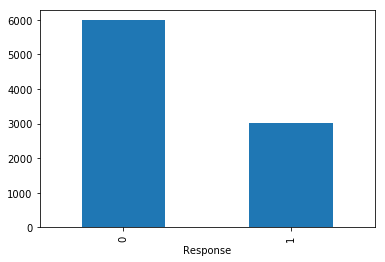

time: 357 ms


In [74]:
sample_num.groupby(['Response']).count()['Id'].plot.bar(stacked=True)

In [75]:
sample_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9019 entries, 101 to 83488
Columns: 970 entries, Id to Response
dtypes: float64(968), int64(2)
memory usage: 66.8 MB
time: 20 ms


confirming all rows

In [76]:
len(set(tot_samp_id).intersection(set(sample_num.Id.tolist()))),len(set(tot_samp_id).union(set(sample_num.Id.tolist())))

(9019, 9019)

time: 94 ms


common id in sample

In [77]:
set(sam0_id).intersection(set(sam1_id))

set()

time: 86 ms


In [78]:
sample_num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
101,208,0.128,0.108,-0.197,-0.161,0.161,0.025,-0.030,-0.152,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
122,256,-0.036,-0.108,0.294,0.294,-0.056,0.070,0.022,0.208,-0.046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
166,337,-0.062,-0.034,0.348,0.330,-0.013,0.070,0.030,0.128,0.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
274,527,-0.153,-0.198,0.312,0.330,0.031,-0.203,0.052,0.288,-0.067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
539,1053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


time: 110 ms


#### Percentage of information available

In [79]:
printmd('### '+str(1.0 * sample_num.count().sum() / sample_num.size))

### 0.190673069339

time: 329 ms


### Load Categorical Sample Data

```
sample_cat = pd.DataFrame() 
for i in tqdm(range(1,25)):
    train_cat_part = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Categorical\\train_'+str(i)+'.gzip', chunksize=rlimit,compression='gzip')
    for chunk in train_cat_part:
        sample_cat=sample_cat.append(chunk[chunk['Id'].isin(tot_samp_id)])
        del chunk
```

### Load Date data for corrosponding sample Ids

In [80]:
sample_date = pd.DataFrame() 
for i in tqdm(range(1,120)):
    train_date_part = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Date\\train_'+str(i)+'.gzip', chunksize=rlimit,compression='gzip')
    for chunk in train_date_part:
        sample_date=sample_date.append(chunk[chunk['Id'].isin(tot_samp_id)])
        del chunk

100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [02:55<00:00,  1.23s/it]


time: 2min 56s


In [81]:
sample_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9019 entries, 101 to 3488
Columns: 1157 entries, Id to L3_S51_D4263
dtypes: float64(1156), int64(1)
memory usage: 79.7 MB
time: 77 ms


In [82]:
sample_date.head()

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
101,208,168.47,168.47,168.47,168.47,168.47,168.47,168.47,168.47,168.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,256,1112.99,1112.99,1112.99,1112.99,1112.99,1112.99,1112.99,1112.99,1112.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,337,1115.18,1115.18,1115.18,1115.18,1115.18,1115.18,1115.18,1115.18,1115.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,527,1566.22,1566.22,1566.22,1566.22,1566.22,1566.22,1566.22,1566.22,1566.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539,1053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 42 ms


In [83]:
#sample_cat.head()

time: 131 ms


In [84]:
sample_num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
101,208,0.128,0.108,-0.197,-0.161,0.161,0.025,-0.030,-0.152,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
122,256,-0.036,-0.108,0.294,0.294,-0.056,0.070,0.022,0.208,-0.046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
166,337,-0.062,-0.034,0.348,0.330,-0.013,0.070,0.030,0.128,0.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
274,527,-0.153,-0.198,0.312,0.330,0.031,-0.203,0.052,0.288,-0.067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
539,1053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


time: 180 ms


# Confirm writing Directory and File

In [85]:
.

SyntaxError: invalid syntax (<ipython-input-85-8cf8463b34ca>, line 1)

### Write Samples to CSV

In [86]:
sample_num.to_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Samples\\sample_num_bal7.csv')
sample_date.to_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Samples\\sample_date_bal7.csv')

time: 8.15 s


sample_num.iloc[[223]].dropna(axis=1)

sample_cat.iloc[[223]].dropna(axis=1)

sample_date.iloc[[223]].dropna(axis=1)

sample_cat.iloc[:,6].value_counts()

```
uVal=[]
sample_cat_feat = sample_cat.columns.values.tolist()
sample_cat_feat.remove('Id')
j=0
for i in sample_cat_feat:
    uVal.extend(set(sample_cat[i].dropna().values.tolist()))
    j=j+1
    #print i
    #if j==2:
        #break
        ```

#uVal=list(set(uVal))
#uVal

#[i for i in [''.join(i.split('-')) for i in uVal]]

#set(sample_cat['L3_S47_F4146'].dropna().values.tolist())

#set(sample_cat.columns.values.tolist()).intersection(set(sample_num.columns.values.tolist()))

#sample_cat['L3_S32_F3851'].unique()